In [73]:
THRES = 10
UNIT = 111.32
ASN_TO_NAME = dict()
for l in open("asn.txt","r").readlines():
    name, asn = l.strip().split(" ")
    ASN_TO_NAME[asn] = name

In [28]:
from collections import defaultdict, deque
from datetime import datetime
from enum import Enum
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms

In [81]:
class DataManager:
    def __init__(self, filename):
        self.data = defaultdict(lambda: defaultdict(list))
        self.city = defaultdict(set)
        self.counter = defaultdict(lambda: defaultdict(int))
        self.load(filename)
        
    def load(self, filename):
        f = open(f"{filename}", "r")
        for line in f.readlines()[1:] :
            self.process_line(line)
            
    def process_line(self, line):
        split = list(line.strip().split(","))
        date_time, mean, lat, lng, asn = split[:5]
        city = ",".join(split[5:])
        
        if in_tokyo(float(lat), float(lng)):
            self.city['tokyo'].add(city)
            self.counter['tokyo'][asn] += 1
            self.data['tokyo'][date_time].append( (float(mean),) )
        else :
            self.city['others'].add(city)
            self.counter['others'][asn] += 1
            self.data['others'][date_time].append( (float(mean),) )
        
def in_tokyo(lat, lng):
    inside_tokyo = 800 
    tokyo_lat = 35.652832
    tokyo_lng = 139.839478
    dis = ( (lat-tokyo_lat)*UNIT )**2 + ( (lng-tokyo_lng)*UNIT )**2 
    if dis < inside_tokyo :
        return True
    return False

In [30]:
def find_median(data):
    n = len(data)
    if n < THRES :
        return -1
    data.sort()
    return data[n//2][0] if n%2 else (data[n//2-1][0]+data[n//2][0])/2

In [31]:
def build_datetime(dt):
    month, day, year_hour = dt.split("/")
    year, hour = year_hour.split(" ")
    return datetime(int(year), int(month), int(day), int(hour))

def get_index(_dt, _st):
    dt = build_datetime(_dt)
    st = build_datetime(_st)
    return int((datetime.timestamp(dt)-datetime.timestamp(st))//3600)

In [32]:
def build_plot_data(data, st, end):
    x, y = [], []
    for dt in sorted(data.keys()) :
        if dt < st or dt > end:
            continue
        median = find_median(data[dt])
        if median == -1 :
            continue
        x.append(get_index(dt, st))
        y.append(median)
    return  np.array(x),  np.array(y)

In [33]:
def build_plot_data_average_by_day(data, st, end):
    x, y = [], []
    group = defaultdict(list)
    for dt in data.keys():
        if dt < st or dt > end:
            continue
        group_name, _ = dt.split(" ")
        group[group_name].append(dt)
    for g in sorted(group.keys()):
        c = 0
        v = 0
        for dt in group[g]:
            temp = [ x[0] for x in data[dt] ]
            c += len(temp)
            v += sum(temp)
        if c!=0:
            x.append( get_index(g+" 00", st) )
            y.append( v/c )
    return  np.array(x),  np.array(y)

In [34]:
def build_plot_data_median_by_day(data, st, end):
    x, y = [], []
    group = defaultdict(list)
    for dt in data.keys():
        if dt < st or dt > end:
            continue
        group_name, _ = dt.split(" ")
        group[group_name].append(dt)
        
    for g in sorted(group.keys()):
        temp = []
        for dt in group[g]:
            temp += [ x[0] for x in data[dt] ]
        temp.sort()
        n = len(temp)
        if n != 0 :
            x.append( get_index(g+" 00", st) )
            y.append( temp[n//2] if n%2 else (temp[n//2]+temp[n//2-1])/2 )
            
    return  np.array(x),  np.array(y)

In [35]:
def build_bucket(data, st, end):
    size = get_index(end, st)+1
    bucket = [0]*size
    for dt in data:
        if dt < st or dt > end:
            continue
        bucket[get_index(dt, st)] = find_median(data[dt])
    return bucket    
    
def build_plot_data_smooth(data, st, end):
    x, y = [], []
    p = 24
    c = v = 0 
    bucket = build_bucket(data,st,end)
    for i in range(p-1):
        c += 1 if bucket[i] != 0 else 0
        v += bucket[i]
    
    for i in range(p-1, len(bucket)):
        c += 1 if bucket[i] != 0 else 0
        v += bucket[i]
        
        x.append(i-p+1)
        _y = 0 if c == 0 else v/c
        y.append(_y)
    
        c -= 1 if bucket[i-p+1] != 0 else 0
        v -= bucket[i-p+1]
    
    return  np.array(x),  np.array(y)

In [36]:
def get_xticklabels(xticks, st, fmt):
    ref = build_datetime(st)
    ts_ref = datetime.timestamp(ref)
    xticklabels = []
    for t in xticks:
        dt = datetime.fromtimestamp(ts_ref+t*3600)
        xticklabels.append(dt.strftime(fmt))
    return xticklabels

In [64]:
def plot(data, st, end, title):
    fig = plt.figure(figsize=(30,4), dpi=110)
    ax = fig.add_subplot(111)
    x, y = data['build'](data['data'], st, end)
    median = get_median_between(data['data'], data['build'])
    
    xticks = list(range(x[0],x[-1],24*7))
    xticklabels = get_xticklabels(xticks, st, "%h %d")
    
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    
    ax.set_ylabel("Throughput (MBpS)")
    ax.set_xlabel("Date")
    ax.set_ylim(0, median*2.5)
    ax.grid()
    
    ax.axhline(median, ls= '--',color='grey', lw=2, alpha=0.9)  
    ax.plot(x,y,"-", color='black')    
    
    trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
    ax.fill_between(x, y, median, where=y > median, facecolor='lightblue', interpolate=True)
    ax.fill_between(x, y, median, where=y < median, facecolor='red', alpha=0.4, interpolate=True)
    
    fig.savefig(f"img/loc/{title}.png")

In [38]:
def get_median_between(data, func, st='01/01/2020 00', end='03/01/2020 00'):
    x, y = func(data, st, end)
    y.sort()
    n = len(y)
    result = y[n//2] if (n%2) else (y[n//2-1]+y[n//2])/2
    return result

In [65]:
def plot_worst_week(data, st, end, title):
    x, y = data['build'](data['data'],st,end)
    median = get_median_between(data['data'], data['build'])
    
    period = 24*14
    res = -1
    
    dq = deque()
    st_idx = 0
    end_idx = get_index(end, st)
    i = bad_index = worst_index = 0
    while st_idx+period < end_idx:
        while dq and dq[0][0] < st_idx:
            if dq[0][1] < median:
                bad_index -= 1
            dq.popleft()
        
        while i < len(x) and x[i] <= st_idx+period:
            dq.append((x[i], y[i]))
            if y[i] < median:
                bad_index += 1
            i += 1
        
        if bad_index > worst_index:
            worst_index = bad_index
            res = st_idx
        
        st_idx += 1
    
    fig = plt.figure(figsize=(30,4), dpi=110)
    ax = fig.add_subplot(111)
    x = x[res:res+period+1]
    y = y[res:res+period+1] 
    
    xticks = list(range(x[0],x[-1],12))
    xticklabels = get_xticklabels(xticks, st, "%H:%M\n%h %d")
    
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    
    ax.set_ylabel("Throughput (MBpS)")
    ax.set_xlabel("Date")
    ax.grid()
    
    ax.axhline(median, ls= '--',color='grey', lw=2, alpha=0.9)  
    ax.plot(x,y,"-", color='black')    
    
    trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
    ax.fill_between(x, y, median, where=y > median, facecolor='lightblue', interpolate=True)
    ax.fill_between(x, y, median, where=y < median, facecolor='red', alpha=0.4, interpolate=True)
    
    fig.savefig(f"img/loc-worst/{title}.png")    

In [85]:
# bq = DataManager("bq-city.csv")
# bq.city['tokyo']

In [86]:
for key in ['tokyo', 'others']:
    print(key)
    c = 0 
    for asn in bq.counter[key]:
        c += bq.counter[key][asn]
    
    res = []
    total = 0
    for asn in bq.counter[key]:
        if asn in ASN_TO_NAME :
            res.append( (100*bq.counter['tokyo'][asn]/c, ASN_TO_NAME[asn]) )
            total += 100*bq.counter['tokyo'][asn]/c
            
    print("total : ", total)
    for r in sorted(res, reverse=True):
        print(r)
    print(c)

tokyo
total :  81.83971276931523
(26.218142930404085, 'SOFTBANK')
(22.072734729930694, 'KDDI')
(10.782542007896044, 'NTT')
(5.5228401252491945, 'SONET')
(3.4576257144740765, 'ARTERIA')
(3.255294707247219, 'IIJ')
(2.973311910050215, 'DOCOMO')
(2.59430591071415, 'UCOM')
(2.1911607953918937, 'BIGGLOBE')
(2.05954062460072, 'JCOM')
(0.6985320500366681, 'OPTAGE')
(0.013681263320270498, 'CTC')
6856092
others
total :  59.64827012228679
(19.10889980791598, 'SOFTBANK')
(16.087549662101576, 'KDDI')
(7.858776094495686, 'NTT')
(4.025281229439786, 'SONET')
(2.520064961372179, 'ARTERIA')
(2.3725975013237735, 'IIJ')
(2.1670764225236137, 'DOCOMO')
(1.8908406995306917, 'UCOM')
(1.5970113601608875, 'BIGGLOBE')
(1.5010809709252466, 'JCOM')
(0.5091199247864927, 'OPTAGE')
(0.009971487710885537, 'CTC')
9406821


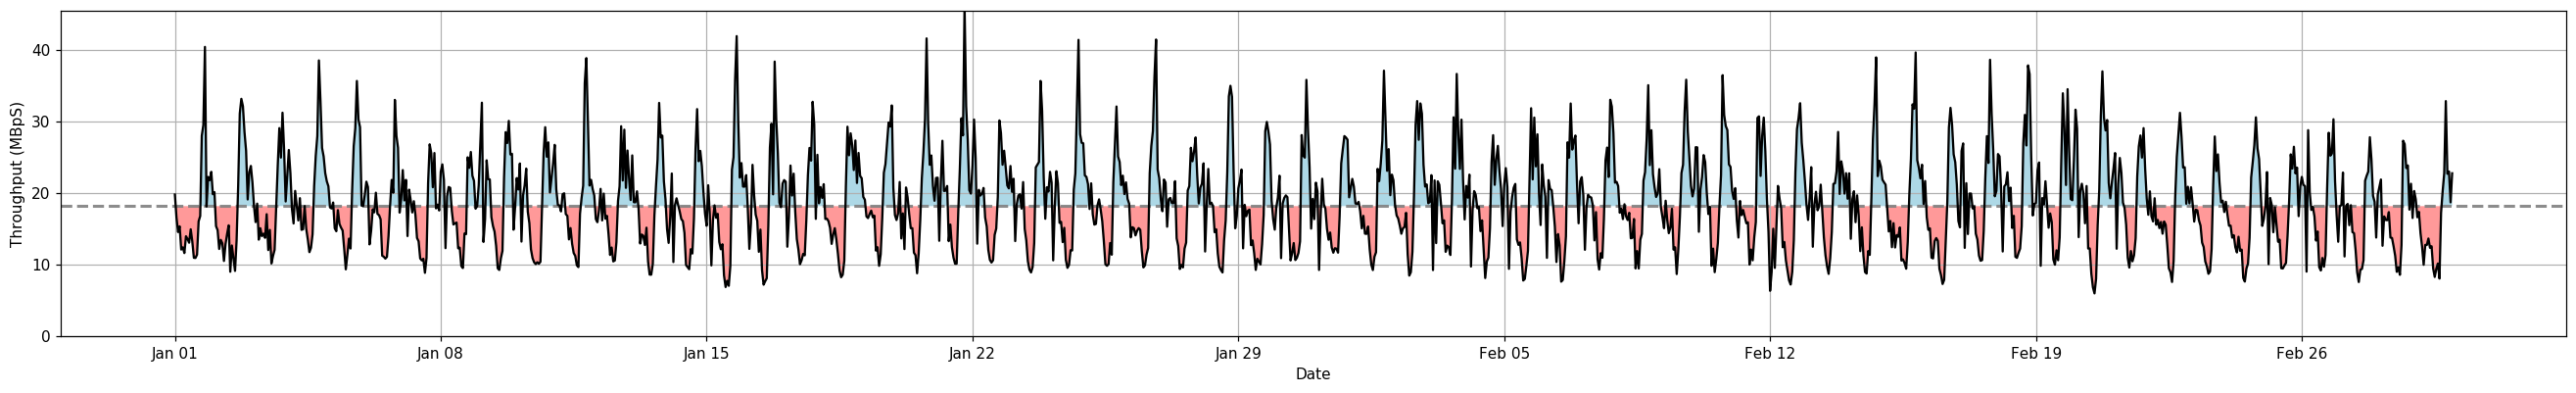

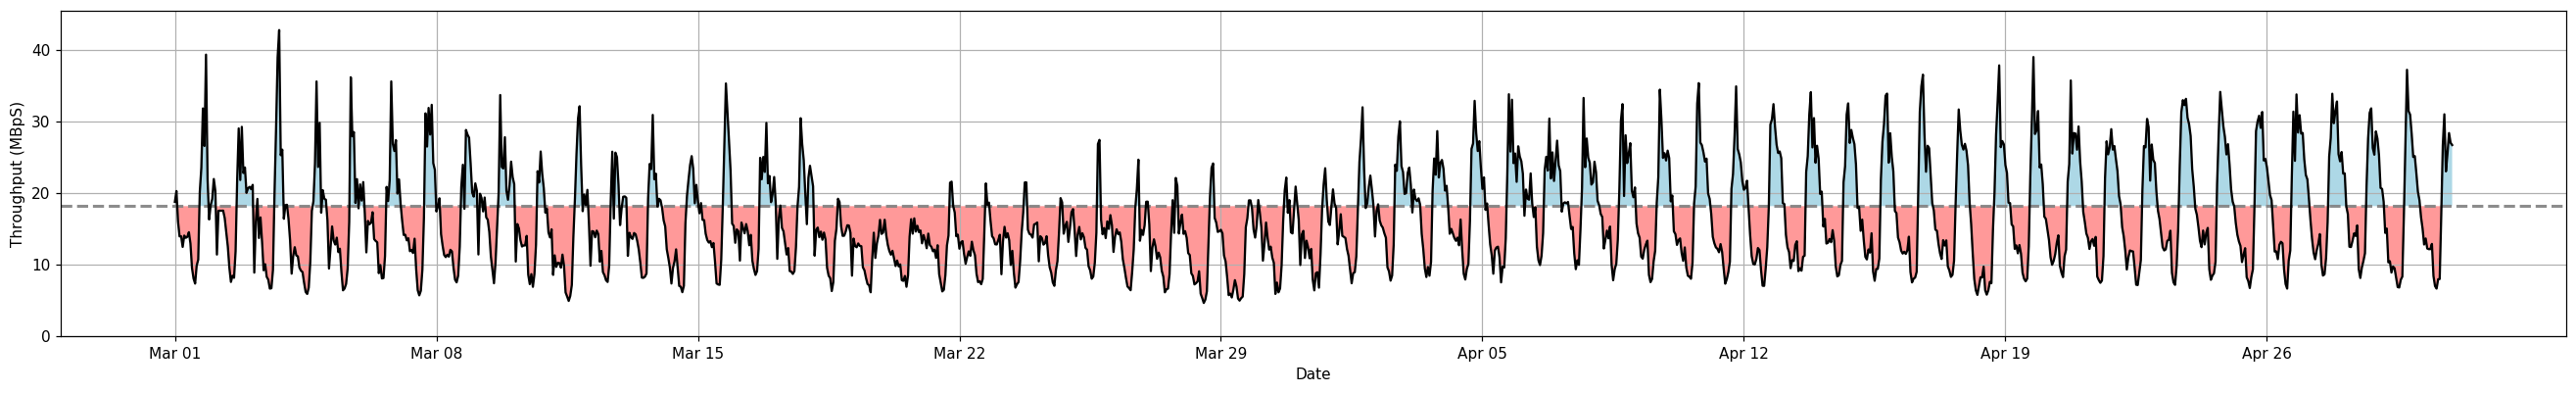

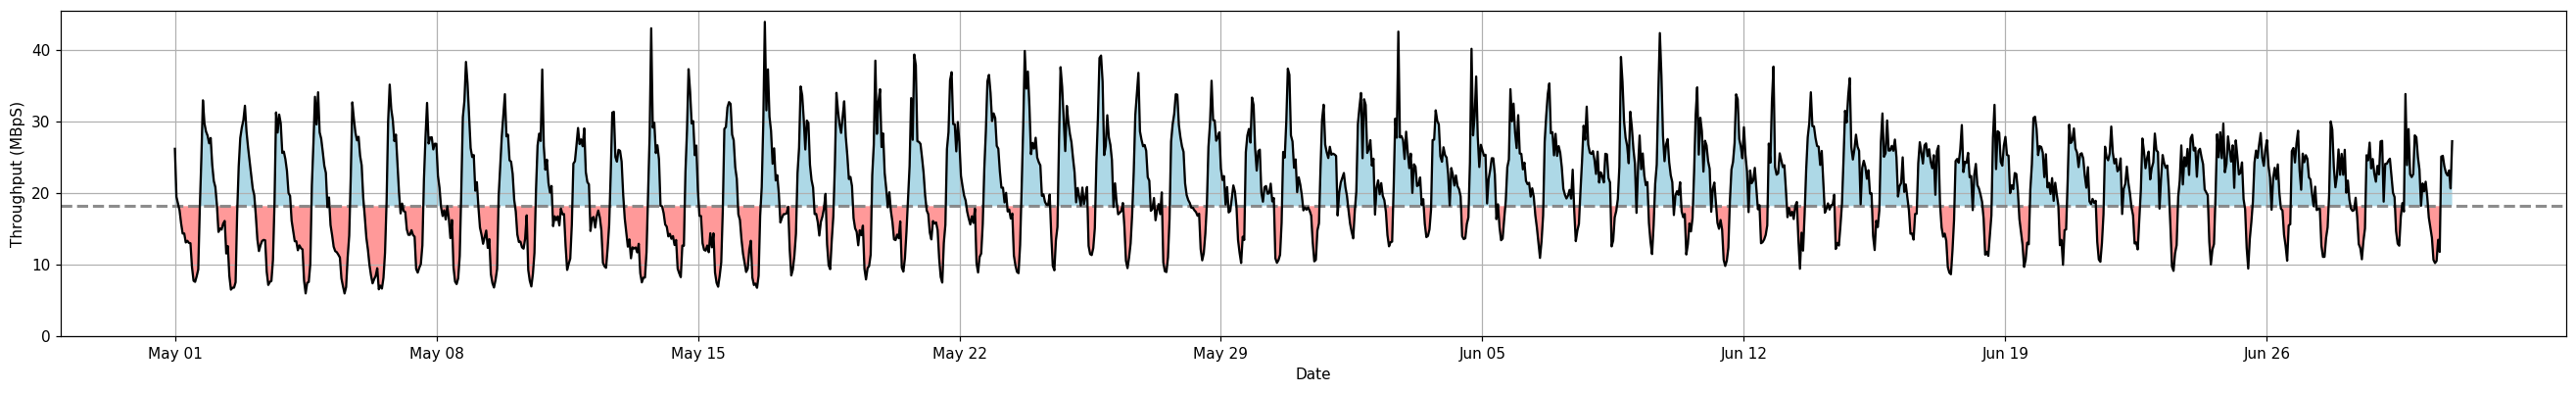

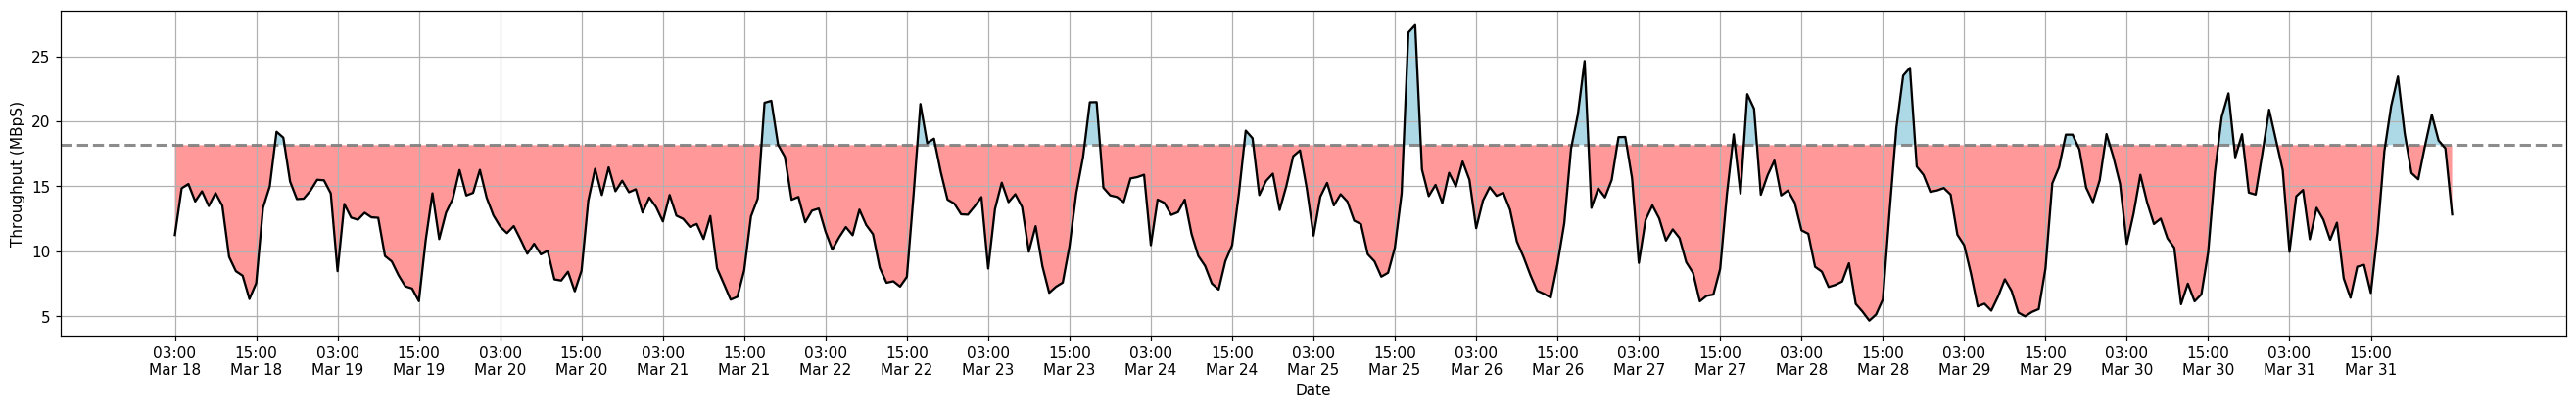

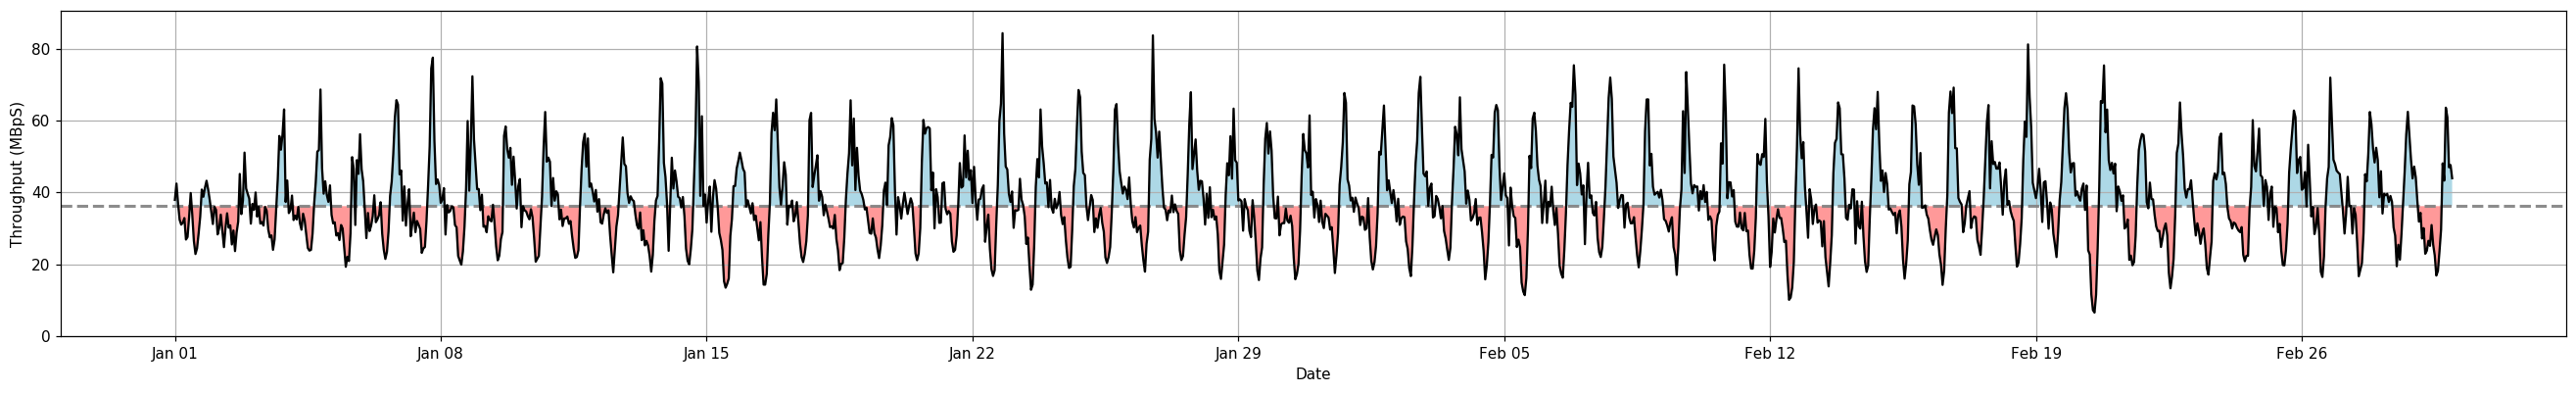

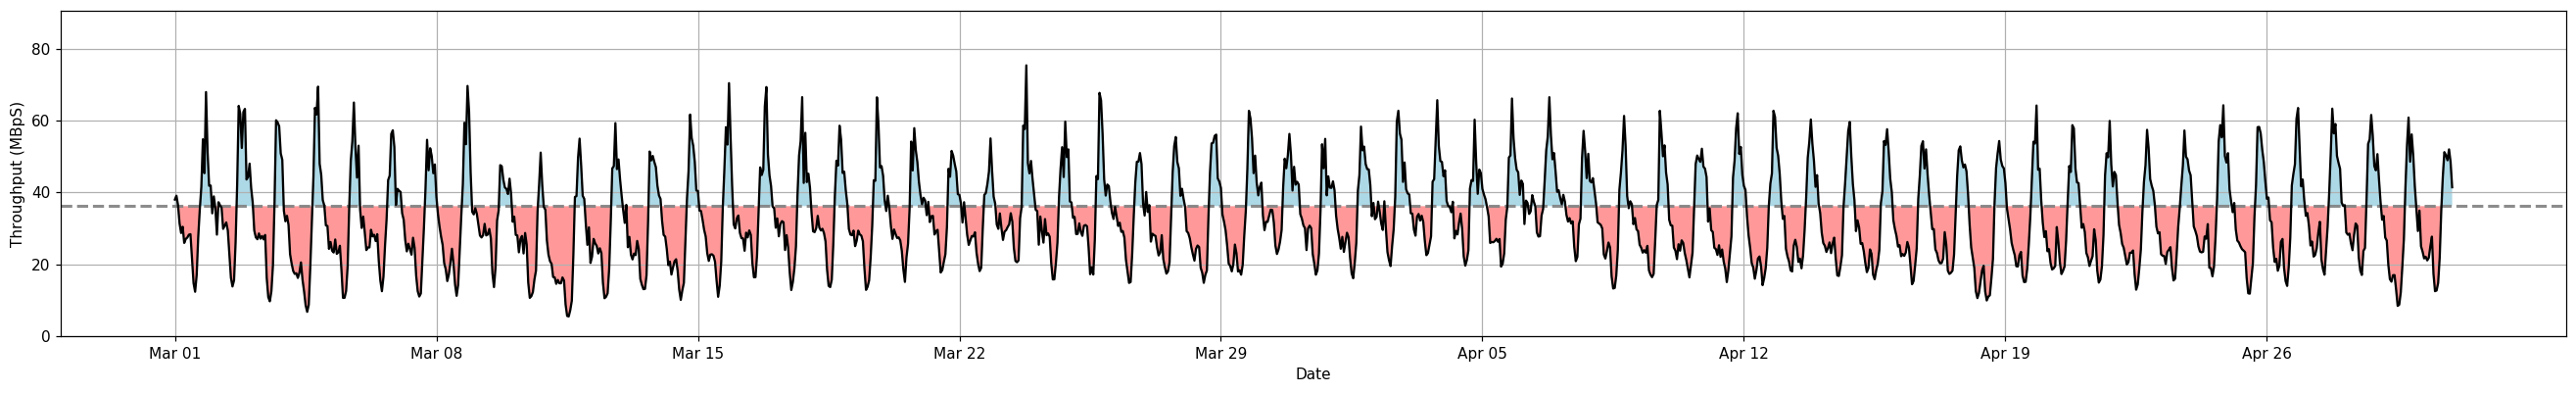

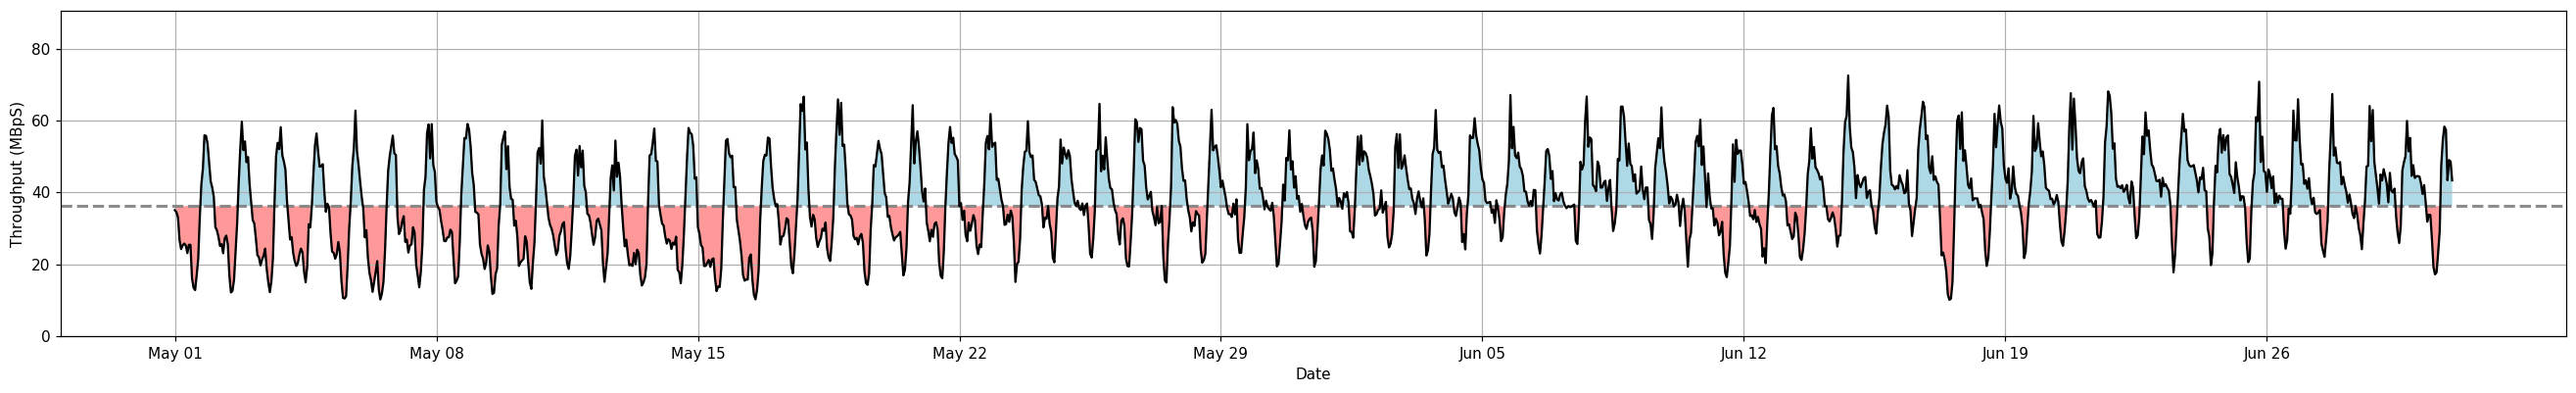

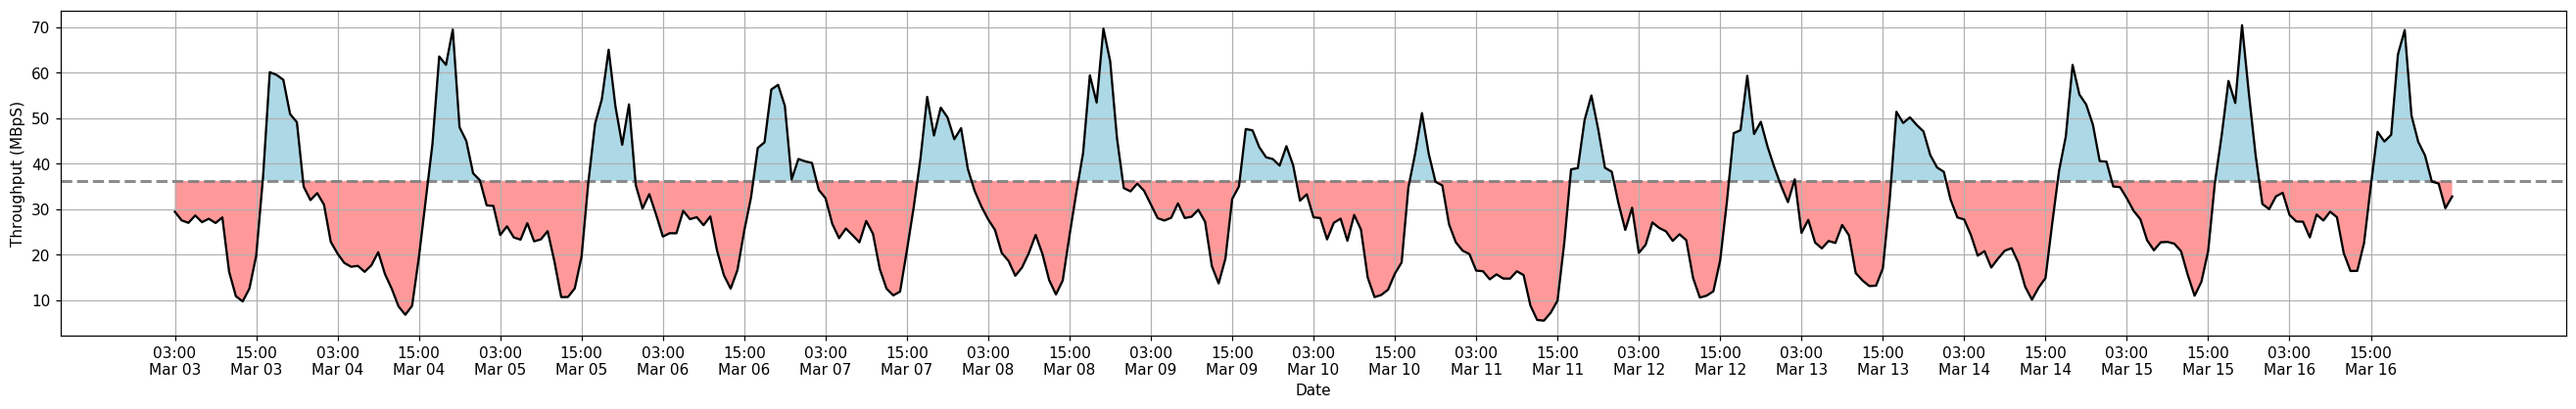

In [60]:
for loc in ['tokyo', 'others'] :
    data = {
        'data': bq.data[loc],
        'build': build_plot_data
    }
#     plot(data, '01/01/2020 00', '02/29/2020 23', f"{loc}-Jan-Feb-full")
    
#     plot(data, '03/01/2020 00', '04/30/2020 23', f"{loc}-Mar-Apr-full")
#     plot(data, '05/01/2020 00', '06/30/2020 23', f"{loc}-May-Jun-full")
#     plot_worst_week(data, '01/01/2020 00', '06/30/2020 23', f"{loc}-worst-2-weeks")